In [8]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate();
#import Pkg; Pkg.activate(joinpath(@__DIR__,"..")); Pkg.instantiate()

  Activating environment at `~/.julia/dev/iLQGameSolver/examples/Project.toml`


In [17]:
using Revise
using LinearAlgebra
using Plots
using SparseArrays
using Random
using Test
using StaticArrays
using iLQGameSolver
using BenchmarkTools
using JLD2
include("monteCarlo.jl")

initTwoQuadcopters (generic function with 1 method)

### 2D Point Mass Continous dynamics

The 2D point masses with mass $m=1\; \text{kg}$ are subject to input forces $F_{ext}$ and damping coefficient $c = 0.1\;[N \cdot \frac{s}{m}]$.


\begin{split}
\dot p &= v\\
\dot v &= -\frac{b}{m}v + \frac{1}{m}F_{ext}
\end{split}

#### Point Mass Discrete

The discrete time linear dynamics for two 2D point masses are as described below: 
$$\begin{equation}
    x_{t+1} = A_tx_t + B^1_tu^1_t + B^2_tu^2_t
\end{equation} $$
where the $A_t$ matrix is:
$$\begin{equation}
    A_t = \begin{bmatrix}   1 & 0 & h & 0 & 0 & 0 & 0 & 0               \\ 
                            0 & 1 & 0 & h & 0 & 0 & 0 & 0               \\ 
                            0 & 0 & 1-(c/m_1)*h & 0 & 0 & 0 & 0 & 0     \\ 
                            0 & 0 & 0 & 1-(c/m_1)*h & 0 & 0 & 0 & 0     \\
                            0 & 0 & 0 & 0 & 1 & 0 & h & 0               \\ 
                            0 & 0 & 0 & 0 & 0 & 1 & 0 & h               \\ 
                            0 & 0 & 0 & 0 & 0 & 0 & 1-(c/m_2)*h & 0     \\ 
                            0 & 0 & 0 & 0 & 0 & 0 & 0 & 1-(c/m_2)*h     \\ 
    \end{bmatrix}
\end{equation} $$
the $B^1_t$ and $B^2_t$ matrices are:
$$\begin{equation}
    B^1_t = \begin{bmatrix} 0 & 0       \\ 
                            0 & 0       \\ 
                            h/m_1 & 0   \\ 
                            0 & h/m_1   \\ 
                            0 & 0       \\ 
                            0 & 0       \\ 
                            0 & 0       \\ 
                            0 & 0       \\
    \end{bmatrix},
    B^2_t = \begin{bmatrix} 0 & 0       \\ 
                            0 & 0       \\ 
                            0 & 0       \\ 
                            0 & 0       \\ 
                            0 & 0       \\ 
                            0 & 0       \\ 
                            h/m_2 & 0   \\ 
                            0 & h/m_2   \\
    \end{bmatrix}
\end{equation} $$
the $x_t$, $u^1_t$, and $u^2_t$ vectors are:
$$\begin{equation}
    x_t = \begin{bmatrix}   x_1         \\ 
                            y_1         \\ 
                            \dot{x}_1   \\ 
                            \dot{y}_1   \\ 
                            x_2 \\ y_2  \\ 
                            \dot{x}_2   \\ 
                            \dot{y}_2   \\
    \end{bmatrix},
    u^1_t = \begin{bmatrix} u^1_x   \\
                            u^1_y   \\
    \end{bmatrix},
    u^2_t = \begin{bmatrix} u^2_x   \\ 
                            u^2_y   \\ 
    \end{bmatrix}
\end{equation} $$

The variables $c$, $h$, $m_1$, and $m_2$ are the damping coefficients [N-s/m], time steps [s], mass of the first agent [kg], and mass of the second agent [kg], respectively.

$$\begin{bmatrix} S11 & S12 \\ S21 & S22 \end{bmatrix}
\begin{bmatrix} P1 \\ P2 \end{bmatrix} = 
\begin{bmatrix} Y1 \\ Y2 \end{bmatrix}$$

$$ \begin{bmatrix} R^{11} + (B^{1'} * V₁ * B^1) & (B^{1'} * V₁ * B^2) \\ (B^{2'} * V_2 * B^1) & R^{22} + (B^{2'} * V_2 * B^2) \end{bmatrix}$$

<!-- $$ \frac{d}{dt}x = Ax + \sum Bu$$

Single 2D point mass:
$$\frac{d}{dt}\begin{bmatrix} x \\ y \\ \dot{x} \\ \dot{y}\end{bmatrix} =  
 \begin{bmatrix} 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \\ 0 & 0 & -c/m & 0 \\ 0 & 0 & 0 & -c/m \end{bmatrix}
 \begin{bmatrix} x \\ y \\ \dot{x} \\ \dot{y}\end{bmatrix} + 
 \begin{bmatrix} 0 & 0 \\ 0 & 0 \\ 1/m & 0 \\ 0 & 1/m \end{bmatrix}
 \begin{bmatrix} u_x \\ u_y\end{bmatrix} $$

two 2D point masses:
$$\frac{d}{dt}\begin{bmatrix} x_1 \\ y_1 \\ \dot{x}_1 \\ \dot{y}_1 \\ x_2 \\ y_2 \\ \dot{x}_2 \\ \dot{y}_2\end{bmatrix} =  
 \begin{bmatrix} 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0\\ 
                0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 \\ 
                0 & 0 & -c/m_1 & 0 & 0 & 0 & 0 & 0\\ 
                0 & 0 & 0 & -c/m_1 & 0 & 0 & 0 & 0\\
                0 & 0 & 0 & 0 & 0 & 0 & 1 & 0\\ 
                0 & 0 & 0 & 0 & 0 & 0 & 0 & 1\\ 
                0 & 0 & 0 & 0 & 0 & 0 & -c/m_2 & 0\\ 
                0 & 0 & 0 & 0 & 0 & 0 & 0 & -c/m_2\\ \end{bmatrix}
 \begin{bmatrix} x_1 \\ y_1 \\ \dot{x}_1 \\ \dot{y}_1 \\ x_2 \\ y_2 \\ \dot{x}_2 \\ \dot{y}_2\end{bmatrix} + 
 \begin{bmatrix} 0 & 0 \\ 0 & 0 \\ 1/m_1 & 0 \\ 0 & 1/m_1 \\ 0 & 0 \\ 0 & 0 \\ 0 & 0 \\ 0 & 0\end{bmatrix}
 \begin{bmatrix} u_x^1 \\ u_y^1 \end{bmatrix} +
 \begin{bmatrix} 0 & 0 \\ 0 & 0 \\ 0 & 0 \\ 0 & 0 \\ 0 & 0 \\ 0 & 0 \\ 1/m_2 & 0 \\ 0 & 1/m_2\end{bmatrix}
 \begin{bmatrix} u_x^2 \\ u_y^2 \end{bmatrix}  $$ -->


## 3 Point Masses Monte Carlo

In [18]:
xEnd, all_rollouts = MonteCarloRollouts(5, initThreePointMasses,iLQGameSolver.pointMass, iLQGameSolver.costPointMass,12);

InterruptException: InterruptException:

In [226]:
xEnd

12×1 Matrix{Float64}:
  4.999973199848165
  9.998703200384334
  4.275562201853588e-5
  0.0026184404536604925
  9.999822816403315
  5.000265505488366
  0.0007403807408187115
 -0.0005059813429485681
  9.99862057285808
  9.999786933988764
  0.002784454154961491
  0.0008000918229612292

## 2 Quadcopters Monte Carlo

In [255]:
cpi_all

1099-element Vector{Any}:
 Any[1, [7994.008777619064, 8199.176733372931]]
 Any[2, [6801.812224567531, 7276.990995464612]]
 Any[3, [5788.254029726382, 5823.298091304413]]
 Any[4, [5941.654320665628, 5943.262831550572]]
 Any[5, [5507.219373513861, 5499.072252640812]]
 Any[6, [5329.928503413897, 5319.364732530331]]
 Any[7, [5265.836509625379, 5257.563057046322]]
 Any[8, [5224.343642043175, 5214.614579254425]]
 Any[9, [5208.554074371927, 5198.3869662642755]]
 Any[10, [5188.9262384312615, 5180.442258042635]]
 ⋮
 Any[1, [7.474875699803942, 7.475134006378625]]
 Any[1, [7.500458358559007, 7.500719552183848]]
 Any[1, [7.526067529934386, 7.526331616564996]]
 Any[1, [7.551703111234618, 7.551970096741227]]
 Any[1, [7.5773649973023645, 7.57763488756627]]
 Any[1, [7.603053080614845, 7.603325881529297]]
 Any[1, [7.628767251667199, 7.6290429690447725]]
 Any[1, [7.65450739914069, 7.654786038801043]]
 Any[1, [7.6802734100905665, 7.680554977772812]]

In [58]:
cpi_all = load_object("pointMassMonteCarlo.jld2");
cpi_all_comb = reduce(vcat, cpi_all);
cpi_all_comb = sort(cpi_all_comb)
#for i in 1:length(cpi_all_comb)
    
costs = reduce(hcat, cpi_all_comb)
costs
idx = convert(Array{Int64,1}, costs[1,:])
costs_p = costs[2,:]
#typeof(idx)
costs_avg = vcat([mean(costs_p[ai .∈ idx,:], dims=1) for ai in unique(idx)]...)

277×1 Matrix{Vector{Float64}}:
 [16760.813015060125, 16777.248679878314, 33400.51700638539]
 [11054.433073183007, 11041.926101702758, 31334.701689145124]
 [8557.28867666636, 8551.529438982465, 21052.567085972536]
 [9668.641928745461, 9646.000540139918, 17603.411633550215]
 [8338.539574685867, 8328.666432843831, 16373.364681562318]
 [7673.529666115443, 7625.104230029304, 15736.641982663408]
 [7335.904958903345, 7286.008655815703, 15486.73752372804]
 [7399.851688343505, 7449.109709201629, 15234.162240289483]
 [9925.274314180668, 9938.168435100086, 16636.269697515927]
 [11690.107684786375, 11952.685655404423, 17797.974882126608]
 ⋮
 [3895.4325352762166, 3207.9952116689124, 7129.017504711846]
 [3895.448386324771, 3207.9952040007365, 7129.019463881777]
 [3895.465206060379, 3207.9951962597743, 7129.02214820359]
 [3895.4821145635556, 3207.9951516952956, 7129.025236077255]
 [3895.5001037566817, 3207.995118531959, 7129.029717505536]
 [3895.514465521578, 3207.9951260729567, 7129.034513116939]
 [

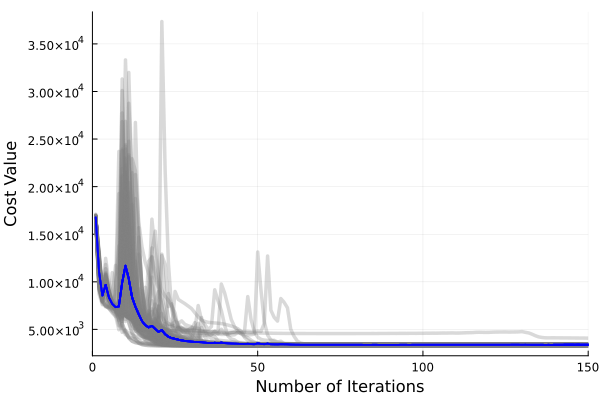

"/Users/mohsafwat/.julia/dev/iLQGameSolver/examples/MonteCarloRollouts.png"

In [87]:
#save_object("pointMassMonteCarlo.jld2", all_rollouts)

P = plot()
iteration_avg = zeros(length(costs_avg))
player1_avg = zeros(length(costs_avg))
for i in 1:length(costs_avg)
    iteration_avg[i] = i
    player1_avg[i] = costs_avg[i][1]
end
for i in 1:length(cpi_all)
    iteration = zeros(length(cpi_all[i]))
    player1_cost = zeros(length(cpi_all[i]))
    player2_cost = zeros(length(cpi_all[i]))
    player3_cost = zeros(length(cpi_all[i]))
    for j in 1:length(cpi_all[i])
        iteration[j] = cpi_all[i][j][1]
        player1_cost[j] = cpi_all[i][j][2][1]
        player2_cost[j] = cpi_all[i][j][2][2]
        player3_cost[j] = cpi_all[i][j][2][3]
    end
    plot!(P,iteration, player1_cost, legend=false, linealpha = 0.3, linewidth = 3.5, 
        color = "grey", 
        xlim=(0, 150),
        xaxis = "Number of Iterations", 
        yaxis = "Cost Value")
    plot!(P,iteration_avg, player1_avg, legend=false, linealpha = 1.5, linewidth = 1.8, color = "blue", label = "Average")

    #plot!(P,iteration, player2_cost, legend=false, linealpha = 0.2, linewidth = 3.5, color = "red")#, ylim=(0, 30000), xlim=(0, 200))
    #plot!(P,iteration, player3_cost, legend=false, linealpha = 0.2, linewidth = 3.5, color = "green")#, ylim=(0, 30000), xlim=(0, 200))
end
#annotate!(125,30000, "Average ---", color = "blue")
display(P)
#savefig(P, "MonteCarloRollouts")

In [60]:
iteration_avg

277-element Vector{Float64}:
   1.0
   2.0
   3.0
   4.0
   5.0
   6.0
   7.0
   8.0
   9.0
  10.0
   ⋮
 269.0
 270.0
 271.0
 272.0
 273.0
 274.0
 275.0
 276.0
 277.0

In [ ]:
X[end,:,:]

In [69]:
xend = X[end,:,:]

@test xend[1] ≈ xgoal[1] atol=1e-2 
@test xend[2] ≈ xgoal[2] atol=1e-2 
@test xend[3] ≈ xgoal[3] atol=1e-2 
@test xend[4] ≈ xgoal[4] atol=1e-2 
@test xend[5] ≈ xgoal[5] atol=1e-2 
@test xend[6] ≈ xgoal[6] atol=1e-2 
@test xend[7] ≈ xgoal[7] atol=1e-2 
@test xend[8] ≈ xgoal[8] atol=1e-2 
@test xend[9] ≈ xgoal[9] atol=1e-2 
@test xend[10] ≈ xgoal[10] atol=1e-2 
@test xend[11] ≈ xgoal[11] atol=1e-2 
@test xend[12] ≈ xgoal[12] atol=1e-2 

Test Passed

In [ ]:
# Animation of the solution. GIF is saved in the assets folder.

anim = @animate for t in 1:N-1
    scatter([X[t,1,:]], [X[t,2,:]], m = (:circle, 12),
    xlims = (-1, 11), 
    ylims = (-1, 11), 
    legend = false)
    scatter!([X[t,5,:]], [X[t,6,:]], m = (:circle, 12))
    scatter!([X[t,9,:]], [X[t,10,:]], m = (:circle, 12))
    plot!([xgoal[1]], [xgoal[2]], m = (:cross, 12, :blue))
    plot!([xgoal[5]], [xgoal[6]], m = (:cross, 12, :red))
    plot!([xgoal[9]], [xgoal[10]], m = (:cross, 12, :green))
end every 1;
gif(anim, "assets/iLQGameExample.gif")

In [ ]:
# Trajectories of that the agents followed

plot([X[:,1,:]], [X[:,2,:]], xlims = (-1, 11), ylims = (-1, 11), legend = false)
plot!([X[:,5,:]], [X[:,6,:]])
plot!([X[:,9,:]], [X[:,10,:]])
plot!([xgoal[1]], [xgoal[2]], m = (:cross, 12, :blue))
plot!([xgoal[5]], [xgoal[6]], m = (:cross, 12, :red))
plot!([xgoal[9]], [xgoal[10]], m = (:cross, 12, :green))

In [ ]:
# Agent 1's input values 
# y1: F in x 
# y2: F in y

plot(U[:,1:2])

In [ ]:
# Agent 2's input values 
# y1: F in x 
# y2: F in y

plot(U[:,3:4])

In [ ]:
# Agent 3's input values 
# y1: F in x 
# y2: F in y

plot(U[:,5:6])